# 07 - Basic Normalizing Flow Training and Sampling
This notebook is the first in a series of [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl). Here we will layout the basic theory behind [Normalizing Flows (NFs)](https://arxiv.org/abs/1505.05770) and how to use the implementations in InvertibleNetworks.jl to train and sample from a basic Normalizing Flow using the [GLOW](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf) architecture.

The GLOW architecture implements:
* Affine couplying layer from Real-NVP
* Ability to activate multiscale for efficient training and compressive behavior in latent $z$ 
* ActNorms for stable training   
* 1x1 Convolutions for channel mixing between affine couplying layers  



In [1]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux

import Flux.Optimise: ADAM, update!

PyPlot.rc("font", family="serif"); 

┌ Info: Precompiling InvertibleNetworks [b7115f24-5f92-4794-81e8-23b0ddb121d3]
└ @ Base loading.jl:1278


## Target distribution

For this example, we will learn to sample from the [2-D Rosenbrock distribution](https://en.wikipedia.org/wiki/Rosenbrock_function). Accessible in InvertibleNetworks.jl
using its colloquial name: the "banana" distribution. The idea of invertible networks is that we want to learn an invertible nonlinear mapping $G$ such that

$$G_{\theta}(x) = z,$$

where $\theta$ is the network parameter, $x$ samples from the target distribution, $z$ samples from Gaussian distribution (white noise). After training, NF can sample from the target distribution via evaluating the inverse of NF on white noise, i.e., $G^{-1}_{\theta}(z)$. Let's first generate a training set and plot the target banana distribution.

In [2]:
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

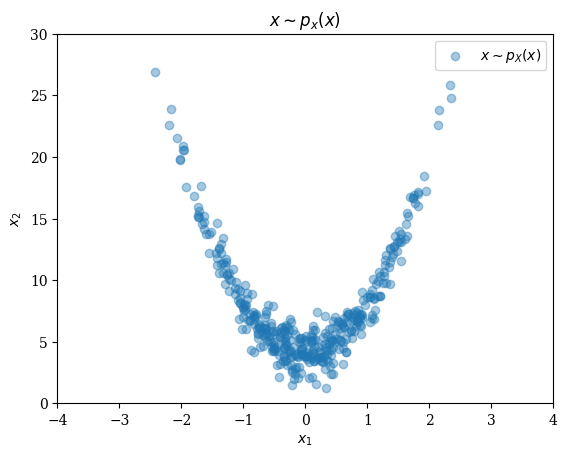

In [3]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

## Change of variables formula

$$p_x(x) = p_z(f(x)) \, |\det \frac{\partial f}{\partial x}|$$

This formula allows us to evaluate the density of a sample under a monotone function $f : \mathbf{X} \rightarrow
 \mathbf{Z}$. 
 
 This density estimation is what gives us a maximum likelihood framework for training our parameterized Normalizing Flow $G_{\theta}$. 

## Training a normalizing flow 

write out the negative log likelihood (nll)
 
NF training is based on likelihood maximization of the parameterized model $f_{\theta}$ under the log likelihood of samples from the data distribution X: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathbb E_{{x} \sim p(x)} [\log p(x)]. $$.

We approximate the expectation with Monte Carlo samples from the training dataset:

$$\underset{\mathbf{\theta}}{\operatorname{argmax}}   \frac{1}{N} \sum_{x \in X_{train}} \log p(x). $$

We make this a minimization problem by looking at the negative loglikelihood and then the change of variabes formula makes this:

$$\underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train}} -\log p(x) = \underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train}}  [\frac{1}{2}\|G_\theta({x})\|_2^2 - \log | \det \nabla_{x} G_\theta(x) | ]  $$

This means that you apply your network to your data $\hat z = G_\theta(x)$ and want $\hat z$ to look like Normal noise. The log det of the jacobian term is making sure that we learn a distribution. 

Calling ``G.backward`` will set all the gradients of the trainable parameters in G. We can access these parameters and their gradients with ``get_params`` and update them with the optimizer of our choice.

Note: since the network is invertible we do not need to save intermediate states to calculate the gradient. Instead, we only provide the ``G.backward`` function with the final output Z and it will recalculate the intermediate states to calculate the gradients at each layer while backpropagating the residual dZ. 

In [4]:
function loss(G, X)
    batch_size = size(X)[end] 
    
    Z, lgdet = G.forward(X)
    
    l2_loss = 0.5*norm(Z)^2 / batch_size  #likelihood under Normal Gaussian training 
    dZ = Z / batch_size                   #gradient under Normal Gaussian training
    
    G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [5]:
nx          = 1
ny          = 1

#network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 16
levels_L    = 1
flowsteps_K = 10

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;)
#G = G |> gpu 

#training parameters
batch_size = 150
maxiter    = cld(n_train, batch_size)

lr = 9f-4
opt = ADAM(lr)

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j = 1:maxiter
    Base.flush(Base.stdout)
    idx = ((j-1)*batch_size+1):(j*batch_size)
    
    X = X_train[:,:,:,idx]
    #x = x |> gpu
    
    losses = loss(G, X) #sets gradients of G
    
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    print("Iter : iteration=", j, "/", maxiter, ", batch=", 
            "; f l2 = ",   loss_l2_list[j], 
            "; f lgdet = ",loss_lgdet_list[j], 
            "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")
     
    for p in get_params(G) 
        update!(opt,p.data,p.grad)
    end
end

Iter : iteration=1/400, batch=; f l2 = 0.6119054158528646; f lgdet = -2.4949865341186523; f nll objective = 3.106891949971517
Iter : iteration=2/400, batch=; f l2 = 1.0596636962890624; f lgdet = -2.4703474044799805; f nll objective = 3.530011100769043
Iter : iteration=3/400, batch=; f l2 = 0.7027423604329427; f lgdet = -2.4711947441101074; f nll objective = 3.1739371045430502
Iter : iteration=4/400, batch=; f l2 = 0.40376459757486977; f lgdet = -2.4689488410949707; f nll objective = 2.8727134386698405
Iter : iteration=5/400, batch=; f l2 = 0.5273852030436198; f lgdet = -2.45419979095459; f nll objective = 2.9815849939982098
Iter : iteration=6/400, batch=; f l2 = 0.5401891581217448; f lgdet = -2.4417061805725098; f nll objective = 2.9818953386942546
Iter : iteration=7/400, batch=; f l2 = 0.5005246480305989; f lgdet = -2.434194803237915; f nll objective = 2.934719451268514
Iter : iteration=8/400, batch=; f l2 = 0.3684675598144531; f lgdet = -2.416494846343994; f nll objective = 2.7849624

Iter : iteration=66/400, batch=; f l2 = 0.9694507853190104; f lgdet = -1.2626423835754395; f nll objective = 2.23209316889445
Iter : iteration=67/400, batch=; f l2 = 0.723633524576823; f lgdet = -1.2452776432037354; f nll objective = 1.9689111677805582
Iter : iteration=68/400, batch=; f l2 = 1.0049263509114583; f lgdet = -1.2141809463500977; f nll objective = 2.219107297261556
Iter : iteration=69/400, batch=; f l2 = 0.8237981160481771; f lgdet = -1.1824368238449097; f nll objective = 2.006234939893087
Iter : iteration=70/400, batch=; f l2 = 1.8798140462239583; f lgdet = -1.2488486766815186; f nll objective = 3.128662722905477
Iter : iteration=71/400, batch=; f l2 = 0.7835495503743489; f lgdet = -1.1502697467803955; f nll objective = 1.9338192971547445
Iter : iteration=72/400, batch=; f l2 = 1.0876932779947917; f lgdet = -1.2341763973236084; f nll objective = 2.3218696753184
Iter : iteration=73/400, batch=; f l2 = 0.843839111328125; f lgdet = -1.151214838027954; f nll objective = 1.9950

Iter : iteration=131/400, batch=; f l2 = 0.7566635640462239; f lgdet = -0.5949875712394714; f nll objective = 1.3516511352856955
Iter : iteration=132/400, batch=; f l2 = 0.5874641927083334; f lgdet = -0.4973124861717224; f nll objective = 1.084776678880056
Iter : iteration=133/400, batch=; f l2 = 0.8984597778320312; f lgdet = -0.6345480680465698; f nll objective = 1.533007845878601
Iter : iteration=134/400, batch=; f l2 = 1.0958754475911459; f lgdet = -0.569765567779541; f nll objective = 1.6656410153706869
Iter : iteration=135/400, batch=; f l2 = 0.8108290608723958; f lgdet = -0.5038875341415405; f nll objective = 1.3147165950139363
Iter : iteration=136/400, batch=; f l2 = 0.99046142578125; f lgdet = -0.44944995641708374; f nll objective = 1.4399113821983338
Iter : iteration=137/400, batch=; f l2 = 0.910416971842448; f lgdet = -0.5027328729629517; f nll objective = 1.4131498448053996
Iter : iteration=138/400, batch=; f l2 = 0.9165070597330729; f lgdet = -0.4818026125431061; f nll obje

Iter : iteration=195/400, batch=; f l2 = 1.0246371459960937; f lgdet = -0.3603172302246094; f nll objective = 1.384954376220703
Iter : iteration=196/400, batch=; f l2 = 0.8322227478027344; f lgdet = -0.3170170783996582; f nll objective = 1.1492398262023926
Iter : iteration=197/400, batch=; f l2 = 0.9844430541992187; f lgdet = -0.29770034551620483; f nll objective = 1.2821433997154235
Iter : iteration=198/400, batch=; f l2 = 0.9558198038736979; f lgdet = -0.32945168018341064; f nll objective = 1.2852714840571084
Iter : iteration=199/400, batch=; f l2 = 0.9518124389648438; f lgdet = -0.2659737765789032; f nll objective = 1.217786215543747
Iter : iteration=200/400, batch=; f l2 = 0.885205078125; f lgdet = -0.2820919454097748; f nll objective = 1.1672970235347748
Iter : iteration=201/400, batch=; f l2 = 0.8190908304850261; f lgdet = -0.3570193648338318; f nll objective = 1.176110195318858
Iter : iteration=202/400, batch=; f l2 = 0.8491877746582032; f lgdet = -0.22825083136558533; f nll obj

Iter : iteration=259/400, batch=; f l2 = 1.2258256022135416; f lgdet = -0.215943843126297; f nll objective = 1.4417694453398386
Iter : iteration=260/400, batch=; f l2 = 0.9126814778645833; f lgdet = -0.1955212950706482; f nll objective = 1.1082027729352315
Iter : iteration=261/400, batch=; f l2 = 1.0879554239908855; f lgdet = -0.2345517873764038; f nll objective = 1.3225072113672893
Iter : iteration=262/400, batch=; f l2 = 0.8728253173828125; f lgdet = -0.14079445600509644; f nll objective = 1.013619773387909
Iter : iteration=263/400, batch=; f l2 = 0.9734022013346354; f lgdet = -0.11433017253875732; f nll objective = 1.0877323738733926
Iter : iteration=264/400, batch=; f l2 = 1.0295869954427084; f lgdet = -0.13942354917526245; f nll objective = 1.1690105446179708
Iter : iteration=265/400, batch=; f l2 = 1.1495256551106772; f lgdet = -0.1783764362335205; f nll objective = 1.3279020913441977
Iter : iteration=266/400, batch=; f l2 = 1.0690452067057292; f lgdet = -0.2113935351371765; f nl

Iter : iteration=323/400, batch=; f l2 = 0.9387502034505208; f lgdet = -0.11085471510887146; f nll objective = 1.0496049185593923
Iter : iteration=324/400, batch=; f l2 = 1.0008003743489584; f lgdet = -0.18076598644256592; f nll objective = 1.1815663607915243
Iter : iteration=325/400, batch=; f l2 = 1.0450839233398437; f lgdet = -0.1432589292526245; f nll objective = 1.1883428525924682
Iter : iteration=326/400, batch=; f l2 = 0.9860993448893229; f lgdet = -0.14808392524719238; f nll objective = 1.1341832701365153
Iter : iteration=327/400, batch=; f l2 = 0.9841927083333334; f lgdet = -0.07417699694633484; f nll objective = 1.0583697052796683
Iter : iteration=328/400, batch=; f l2 = 1.039241943359375; f lgdet = -0.0999373197555542; f nll objective = 1.1391792631149291
Iter : iteration=329/400, batch=; f l2 = 0.856536153157552; f lgdet = -0.2061653733253479; f nll objective = 1.0627015264829
Iter : iteration=330/400, batch=; f l2 = 0.9760564168294271; f lgdet = -0.07006624341011047; f nll

Iter : iteration=387/400, batch=; f l2 = 1.0719451904296875; f lgdet = -0.1741355061531067; f nll objective = 1.2460806965827942
Iter : iteration=388/400, batch=; f l2 = 0.9306950887044271; f lgdet = -0.13464206457138062; f nll objective = 1.0653371532758076
Iter : iteration=389/400, batch=; f l2 = 0.8932530721028645; f lgdet = -0.09634047746658325; f nll objective = 0.9895935495694478
Iter : iteration=390/400, batch=; f l2 = 0.841249745686849; f lgdet = -0.0597076416015625; f nll objective = 0.9009573872884115
Iter : iteration=391/400, batch=; f l2 = 0.8866358439127604; f lgdet = -0.12626808881759644; f nll objective = 1.0129039327303568
Iter : iteration=392/400, batch=; f l2 = 0.9710696411132812; f lgdet = -0.11766040325164795; f nll objective = 1.088730044364929
Iter : iteration=393/400, batch=; f l2 = 0.8749100748697917; f lgdet = -0.14990293979644775; f nll objective = 1.0248130146662393
Iter : iteration=394/400, batch=; f l2 = 0.9413157145182292; f lgdet = -0.157018780708313; f n

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with qq plots 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

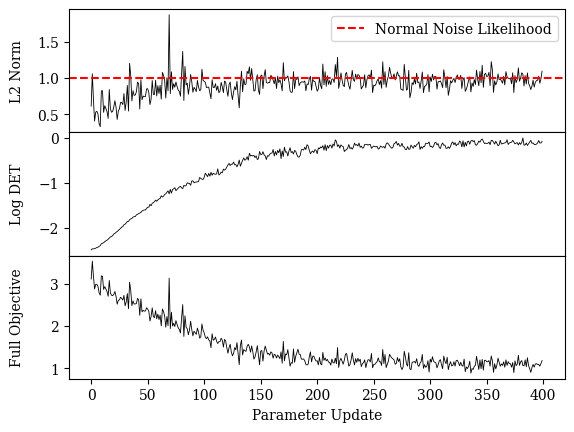

PyObject Text(0.5, 24.0, 'Parameter Update')

In [6]:
gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Take samples from $z \sim N(0,I) $

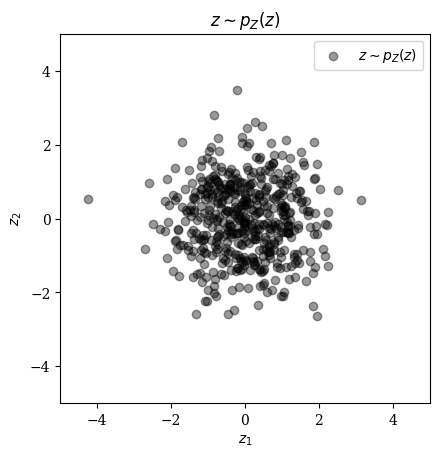

In [7]:
num_test_samples = 500;
Z_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [8]:
X_test = G.inverse(Z_test);

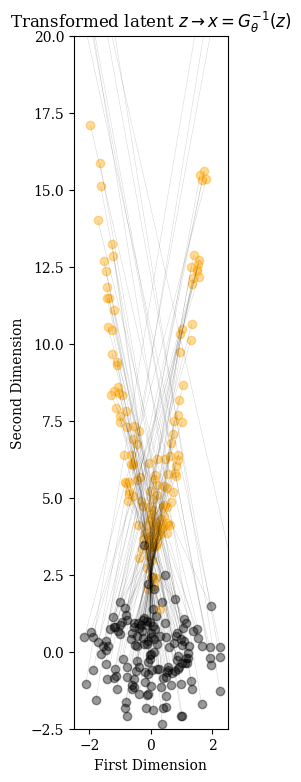

In [9]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

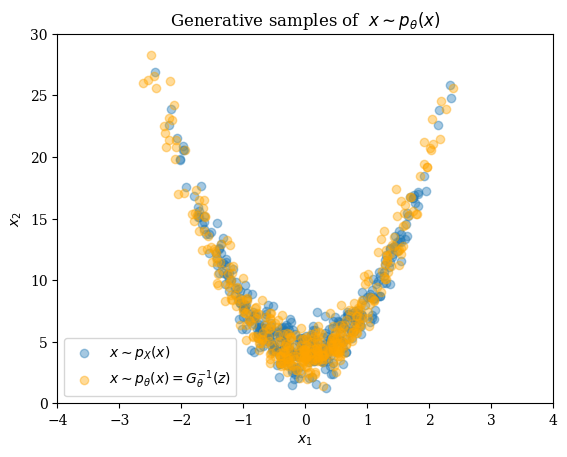

In [10]:
fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();